<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNSPV/notebooky/keras_2020/cv05_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cvičenie 5

Na dnešnom cvičení sa budeme hrať s jedným umelým prípadom. Budeme pracovať s šedotónovými obrázkami do ktorých pridáme vlnivý šum. Ten pridáme pomocou modifikácie obrazu vo Fourierovom spektre. To nám zabezpečí funkcia. Aby sme to upočítali na cvičení, tak budeme pridávať len horizontálny šum. S kódom sa môžete pohrať a skúsiť spojazdniť detekciu aj šikmého šumu.

Všetko budeme testovať na datasete, ktorý je podmnožinou datasetu ImageNet v zmenšenej forme na $91 \times 91$ a obrázky sú šedotónové.

V rámci tohto cvičenie si vytvoríme generátor dát, vlastnú cenovú funkciu a metriku na sledovanie, vlastnú vrstvu siete. 

## Disclaimer

Aby sme si demonštrovali použitie stridu, tak budeme používať konvolučné siete, ktorých architektúra je pre nášu úlohu zbytočne zložitá a nedosahuje ani až také dobré výsledky. Pre tento jednoduchý problém by stačila aj jednoduchá plne prepojená sieť. Z dnešného cvičenia si preto neberte to, ako tvoriť architektúru skôr ako implementovať veci z úloh.

In [1]:
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, Conv2D, Flatten, Input, GlobalAveragePooling2D
from keras.models import Model

import os

Najprv si stiahneme dataset a extrahujeme si ho. V datasete sú tri zložky train, val a mini_train. Mini_train máme na predbežné testovanie tréningu ako sme si ukazovali na druhom cvičení.

In [2]:
!wget http://sccg.sk/~kocur/downloads/dewave_dataset.zip

--2020-11-03 14:18:28--  http://sccg.sk/~kocur/downloads/dewave_dataset.zip
Resolving sccg.sk (sccg.sk)... 158.195.85.131
Connecting to sccg.sk (sccg.sk)|158.195.85.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106631937 (102M) [application/zip]
Saving to: ‘dewave_dataset.zip’

dewave_dataset.zip  100%[===================>] 101.69M  1.58MB/s    in 81s     

2020-11-03 14:19:50 (1.25 MB/s) - ‘dewave_dataset.zip’ saved [106631937/106631937]



In [3]:
!unzip dewave_dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/14441.jpg         
 extracting: train/14442.jpg         
 extracting: train/14443.jpg         
 extracting: train/14444.jpg         
 extracting: train/14445.jpg         
 extracting: train/14446.jpg         
 extracting: train/14447.jpg         
 extracting: train/14448.jpg         
 extracting: train/14449.jpg         
 extracting: train/14450.jpg         
 extracting: train/14451.jpg         
 extracting: train/14452.jpg         
 extracting: train/14453.jpg         
  inflating: train/14454.jpg         
 extracting: train/14455.jpg         
 extracting: train/14456.jpg         
 extracting: train/14457.jpg         
 extracting: train/14458.jpg         
 extracting: train/14459.jpg         
 extracting: train/14460.jpg         
  inflating: train/14461.jpg         
 extracting: train/14462.jpg         
  inflating: train/14463.jpg         
 extracting: train/14464.jpg         
  inflating: train/14465.jpg         

Funkcia predpokladá obrázky v tvare $91 \times 91$.

In [4]:
def add_regular_noise(img, row, col, plot=False):
    # cols in range 1..48
    # rows in range 1..95
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(221), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    val = np.abs(f[0,0])/5

    fshift[row, col] = val
    fshift[90-row, 90-col] = val
    img_modified = np.real(np.fft.ifft2(np.fft.ifftshift(fshift)))

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(223), plt.imshow(np.real(img_modified), cmap='gray')
        plt.title('Output Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(224), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

    return img_modified


def remove_regular_noise(img, row, col, plot=False):
      # cols in range 1..48
    # rows in range 1..95
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(221), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    fshift[row, col] = 0
    fshift[90-row, 90-col] = 0
    img_modified = np.real(np.fft.ifft2(np.fft.ifftshift(fshift)))

    if plot:
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        plt.subplot(223), plt.imshow(np.real(img_modified), cmap='gray')
        plt.title('Output Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(224), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

    return img_modified

Otestujeme na obrázkoch

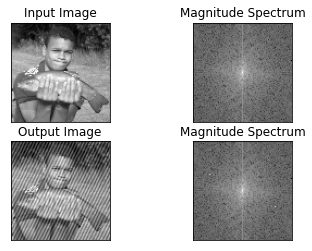

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


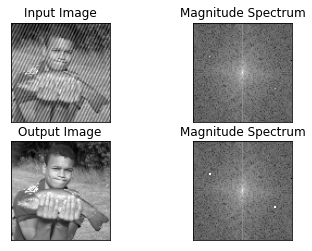

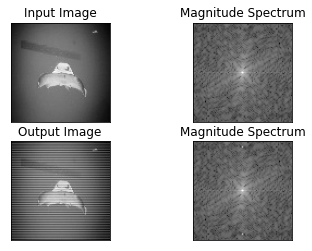

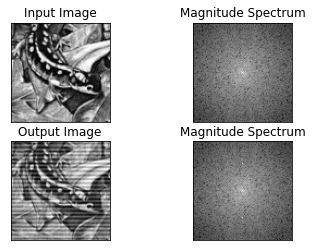

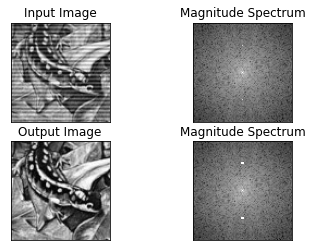

In [5]:
img = cv2.cvtColor(cv2.imread('train/00001.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 30, 15, plot=True)
img_repaired = remove_regular_noise(img_modified, 30, 15, plot=True)

img = cv2.cvtColor(cv2.imread('train/00090.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 5, 45, plot=True)

img = cv2.cvtColor(cv2.imread('train/00450.jpg'),cv2.COLOR_BGR2GRAY)
img_modified = add_regular_noise(img, 20, 45, plot=True)
img_repaired = remove_regular_noise(img_modified, 20, 45, plot=True)


## Generátor dát

Budeme potrebovať generovať dáta pre náš model. Teda vždy do obrázku predtým než ho dáme do siete pridáme náhodné vlnenie.

Na to vytvoríme triedu WaveGenerator, ktorá bude dediť s z keras.utils.Sequence

Aby generátor fungoval, tak potrebujeme tri metódy `__init__`, `__get_item__` a `__len__`. Konštuktor nám pripraví dáta, get_item poskytuje dáta na trénovanie a len povie koľko krokov je jedna epocha.

Je taktiež možné implementovať metódu on_epoch_end. Tá sa používa napríkla na premiešanie datasetu. My budeme vzorky vyberať úplne náhodne preto túto metódu nebudeme potrebovať.

Vaša úloha bude doimplementovať metódu get_item. Zíde sa vám funkcia np.random.randint

In [6]:
class WaveGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dir_path, batch_size=32, steps = 5000):
        'Initialization'
        self.batch_size = batch_size
        self.load_images(dir_path)
        self.steps = steps


    def load_images(self, dir_path):
        files = os.listdir(dir_path)
        images = []
        for file in files:
            file = file.strip()
            images.append(cv2.cvtColor(cv2.imread(os.path.join(dir_path, file)), cv2.COLOR_BGR2GRAY))
        self.images = np.array(images)/255

    def __len__(self):
        # return len(self.images)/self.batch_size
        return self.steps

    def __getitem__(self, index):
        rand_idxs = np.random.randint(0,self.images.shape[0],self.batch_size)
        X = np.empty([self.batch_size,91,91,1])
        y_row = np.empty([self.batch_size, 45])

        for b_idx, idx in enumerate(rand_idxs):
            rand_row = np.random.randint(0,45)
            X[b_idx, :, :, 0] = add_regular_noise(self.images[idx, :, :], rand_row, 45)
            y_row[b_idx, :] = keras.utils.to_categorical(rand_row, 45)

        return X, y_row

    def on_epoch_end(self):
        ...

## Jednoduchá sieť

Generátor môžeme použiť v jednoduchej sieti. Pomocou metódy fit_generator

In [7]:
input = Input(shape=(91,91,1))
conv_1_out = Conv2D(32,(7,7), strides=3, activation='relu')(input)
conv_2_out = Conv2D(32,(5,5), strides=2, activation='relu')(conv_1_out)
conv_3_out = Conv2D(32,(5,5), strides=2, activation='relu')(conv_2_out)
conv_4_out = Conv2D(32,(3,3), activation='relu')(conv_3_out)
conv_5_out = Conv2D(32,(3,3), activation='relu')(conv_4_out)

rows_1_out = Flatten()(conv_5_out)
rows_2_out = Dense(64, activation='relu')(rows_1_out)
rows_3_out = Dense(64, activation='relu')(rows_2_out)
rows_4_out = Dense(45, activation='softmax')(rows_3_out)

model = Model(inputs=input, outputs=rows_4_out)#,cols_4_out])
print(model.summary())

train_gen = WaveGenerator('train', steps=1000)
val_gen = WaveGenerator('val', steps = 200)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_gen, validation_data=val_gen, epochs=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 91, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 29, 29, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 32)               

Model môžeme otestovať

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


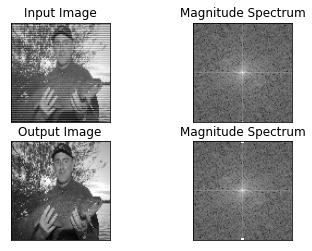

15


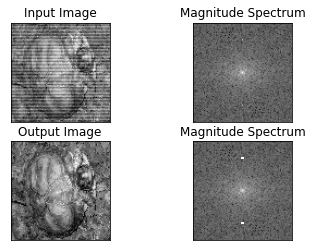

23


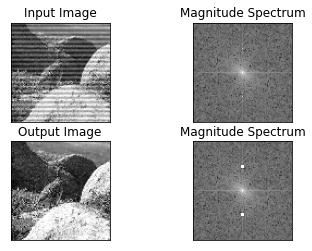

34


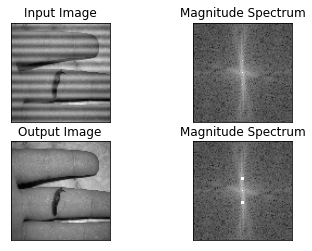

35


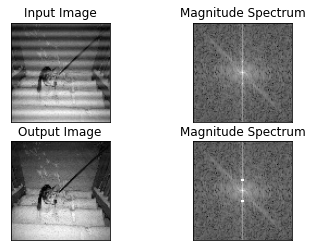

23


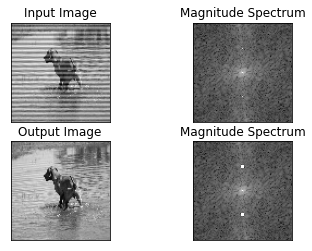

39


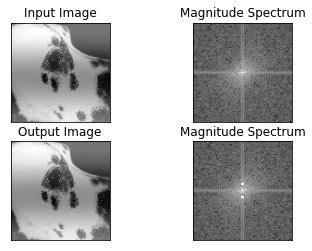

9


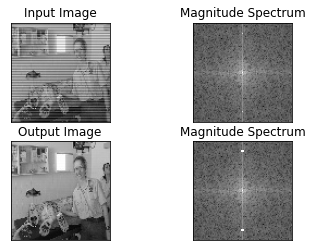

In [8]:
for i in range(8):
  img = cv2.imread('val/{:05d}.jpg'.format(i*100+1))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_modified = add_regular_noise(img, np.random.randint(0,45), 45)
  out = model.predict(img_modified[np.newaxis,:,:,np.newaxis])
  out_row = np.argmax(out[0])
  print(out_row)
  img_repaired = remove_regular_noise(img_modified, out_row, 45, plot=True)

## Regresia
Klasifikácia funguje dobre. V našom prípade má aj celkom dobrý zmysel. Častokrát je však vhodné mať ako výstup modelu nejaké reálne číslo.

Aby sme mohli trénovať sieť tak potrebujeme upraviť náš generátor. To urobíme obdobne ako pri predchádzajúcej úlohe. 

In [9]:
class WaveRegGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dir_path, batch_size=32, steps = 5000):
        'Initialization'
        self.batch_size = batch_size
        self.load_images(dir_path)
        self.steps = steps


    def load_images(self, dir_path):
        files = os.listdir(dir_path)
        images = []
        for file in files:
            file = file.strip()
            images.append(cv2.cvtColor(cv2.imread(os.path.join(dir_path, file)), cv2.COLOR_BGR2GRAY))
        self.images = np.array(images)/255

    def __len__(self):
        # return len(self.images)/self.batch_size
        return self.steps

    def __getitem__(self, index):
        rand_idxs = np.random.randint(0,self.images.shape[0],self.batch_size)
        X = np.empty([self.batch_size,91,91,1])
        y_row = np.empty([self.batch_size])

        for b_idx, idx in enumerate(rand_idxs):
            rand_row = np.random.randint(0,45)
            X[b_idx, :, :, 0] = add_regular_noise(self.images[idx, :, :], rand_row, 45)
            y_row[b_idx] = rand_row

        return X, y_row

    def on_epoch_end(self):
        ...

Model potom bude trocha odlišný na konci bdue len jedna vrstva bez aktivácie.


In [10]:
def build_model():
    input = Input(shape=(91,91,1))
    conv_1_out = Conv2D(32,(7,7), strides=3, activation='relu')(input)
    conv_2_out = Conv2D(32,(5,5), strides=2, activation='relu')(conv_1_out)
    conv_3_out = Conv2D(32,(5,5), strides=2, activation='relu')(conv_2_out)
    conv_4_out = Conv2D(32,(3,3), activation='relu')(conv_3_out)
    conv_5_out = Conv2D(32,(3,3), activation='relu')(conv_4_out)

    rows_1_out = Flatten()(conv_5_out)
    rows_2_out = Dense(64, activation='relu')(rows_1_out)
    rows_3_out = Dense(64, activation='relu')(rows_2_out)
    rows_4_out = Dense(1)(rows_3_out)

    return Model(inputs=input, outputs=rows_4_out)

Trénovať budeme zatiaľ pomocou mean squared error cenovej funkcie.

In [11]:
model = build_model()

print(model.summary())

train_gen = WaveRegGenerator('train', steps=1000)
val_gen = WaveRegGenerator('val', steps = 200)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

history = model.fit_generator(train_gen, validation_data=val_gen, epochs=3)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 91, 91, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        1600      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 32)          25632     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

## Porovnávacia metrika

Pri trénovaní je síce super, že vieme ako sa vyvíja cena a presnosť (po zaokrúhlení), ale to nám nemusí stači. Chceli by sme si navrhnúť vlastnú metriku, ktorá nám viac napovie o vývoji trénovania. To sa nastaštie dá!

Aby sme vyrobili metriku budeme potrebovať funkciu, ktorá na vstupe prijme výsledok siete a trénovacie y a vyhodí číslo. V rámci funkcie ale pracujem s objektmi, ktoré su typovo tenzory. Bežné operácie (+, -, * atď.) fungujú normálne. Na zložitejšie si musíme zavolať funkcie z backendu. V našom prípade to väčšinou znamená volať funkcie tzv. backendu. Keras dokáže bežať na rôznych backendoch preto budeme používať túto abstrakciu. Ak však viete, že budete používať iba tensorflow, tak je samozrejme možné používať priamo tensorflow funkcie.

Teraz si vyrobíme funkciu, ktorá vráti presnosť našej metódy vzhľadom na nejakú toleranicu (napr. 3) teda chceme vedieť aký je podiel výstupov ktoré ležia nejakú vzdialenosť pri výstupe. Na to použijeme backendove metódy abs, less a mean.

Pozn.: Vo funkcii môžeme využívať bežné floaty, alebo aj inak vygenerované vektory.

In [12]:
import keras.backend as K

In [13]:
def acc_within_range(y_pred, y_true):
    return K.mean(K.less(K.abs(y_pred - y_true),3))

In [14]:
model = build_model()

train_gen = WaveRegGenerator('train', steps=1000)
val_gen = WaveRegGenerator('val', steps = 200)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy', acc_within_range])

history = model.fit_generator(train_gen, validation_data=val_gen, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 36s 36ms/step - loss: 44.4554 - accuracy: 0.0267 - acc_within_range: 0.5688 - val_loss: 15.4818 - val_accuracy: 0.0366 - val_acc_within_range: 0.5109
Epoch 2/2
1000/1000 [==============================] - 36s 36ms/step - loss: 4.9906 - accuracy: 0.0406 - acc_within_range: 0.8710 - val_loss: 4.0582 - val_accuracy: 0.0437 - val_acc_within_range: 0.9048


## Vlastná cenová funkcia

MSE nemusí byť úplne najlepšia cenová funkcia aj keď sa bežne využíva. My si definujeme tzv. smooth L1 cenovú funkciu. Tá je podoná L1 norme chyby, až na to, že v okolí nuly je hladká. Definícia je nasledovná:

$$ smooth_{L1}(x) = \begin{cases} \frac{1}{2} x^2 & \mbox{ak}~|x| \le 1 \\|x| - \frac{1}{2} & \mbox{inak} \end{cases}$$

Postupovať budeme obdobne ako pri metrike. Teda vyrobíme funkciu, ktorá ma na vstupe y_pred a y_true. Z backendu sa vám zíde switch, abs a mean.

In [15]:
def smoothL1(y_true, y_pred):
    x   = K.abs(y_true - y_pred)
    x   = K.switch(x < 1, 0.5 * x ** 2, K.abs(x) - 0.5)
    return  K.mean(x)

In [16]:
model = build_model()

train_gen = WaveRegGenerator('train', steps=1000)
val_gen = WaveRegGenerator('val', steps = 200)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss=smoothL1, metrics=['accuracy', acc_within_range])

history = model.fit_generator(train_gen, validation_data=val_gen, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 36s 36ms/step - loss: 3.6086 - accuracy: 0.0331 - acc_within_range: 0.6217 - val_loss: 1.7857 - val_accuracy: 0.0419 - val_acc_within_range: 0.7250
Epoch 2/2
1000/1000 [==============================] - 35s 35ms/step - loss: 0.9185 - accuracy: 0.0394 - acc_within_range: 0.9009 - val_loss: 0.5603 - val_accuracy: 0.0461 - val_acc_within_range: 0.9477


## Vlastná vrstva

Teraz si vyrobíme vlastnú vrstvu. Keďže v našom umelom prípade sa vždy snažíme v podstate identifikovať frekvenciu pridaných vĺn, tak by sme radi identifikovali tieto frekvencie. Na to použijeme konvolúciu s jadrom o rozmeroch $91 \times 1$. Týchto jadier budeme mať viacero a každé jadro bude predstavovať nejakú frekvenciu. Práve frekvencia a fázový posun budú naučiteľné parametre. Hodnoty jadra $w_0, w_1, ... w_90$ pre jednú frekvenciu $\omega$ a fázu $\phi$ budú:

$$ w_k = \mbox{sin}\left( \frac{2\pi \cdot k}{90} \omega + \phi \right)$$.

Pred aplikáciou ešte z obrazu odčítame 0.5 aby to dávalo zmysel. Toto jadro aplikujeme bez paddingu a tak nám akoby eliminuje jednu dimenziu (rád) tenzoru. Takto špecifické jadro samozrejme nebude možné použiť inde ako na začiatku našej siete.

Praktickú implementáciu budeme realizovať podľa [dokmentácie](https://keras.io/layers/writing-your-own-keras-layers/). 

Potrebujeme teda triedu, ktorá dedí od Layer. V konštruktore musím zavolať aj konštruktor predka. V konštruktore si zapamätáme koľko filtrov chceme použiť.

Potom potrebujeme ešte tri metódy. Metóda build berie na vstup tvar vstupu do vrstvy (input_shape). V tejto metóde je nutné nainicializovať trénovateľné premenné. To pre nás bude vektor frekvencií a fáz. Tu sa oplatí ich nainicalizovať ako matice s jednou dimenziou 1. Dôležité je premenné správne nainicializovať. Na to použijeme rovnomernú distribúciu pomocou keras.initializers.RandomUniform. Frekvencie inicializujeme od -100 do 100 a fázu od $-\frac{\pi}{2}$ do $\frac{\pi}{2}$

Ďalej potrebujeme metódu compute_output_shape, ktorá pre tvar vstupu vygeneruje tvar výstupu. Toto je pre nás jednoduché tvar bude rovnaký ako tvar vstupu, okrem výšky obrazu a počtu kanálov.

Nakoniec naimplementujeme metódu call, ktorá sa používa pri trénovaní a inferencii. Ako jediný argument má vstupný tenzor. Vnútornú logiku musím skladať zo základných a backendových funkcií. V nej si najprv vygenerujeme zoznam hodnôt predstavujúci $\frac{2\pi \cdot k}{90}$ a ten potom prenásobíme s fázami, tak aby nám sedeli rozmery (využijeme maticové násobenie aj keď sú to vektory). Potom k nim pričítame fázy. Následne použijeme backendovú funkciu permute_dimensions, ktorou poprehadzujeme jadrá tak aby mali tvar: [filter_height, filter_width, in_channels, out_channels] tj. [91, 1, 1 $n_{filt}$]. Na toto sa nám zíde ešte metóda backendu expand dims aby sme mali čo prehadzovať.

Keď máme kernel pripravený tak ho aplikujeme pomocou backendovej funkcie conv2d na vstupný tenzor ku ktorému ešte pričítame jednu polovicu.



In [17]:
class WaveLayer(keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(WaveLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        freq_init = keras.initializers.RandomUniform(minval=-100, maxval=100, seed=None)
        self.freqs = self.add_weight(name='frequencies', shape=(1,self.output_dim,), initializer=freq_init, trainable=True)
        phase_init = keras.initializers.RandomUniform(minval=-np.pi/2, maxval=np.pi/2, seed=None)
        self.phases = self.add_weight(name='phases', shape=(1,self.output_dim,), initializer=phase_init, trainable=True)

        super(WaveLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        list_x = np.linspace(0,2*np.pi,91)[:, np.newaxis]
        list_phase = list_x * self.freqs + self.phases
        kernel = K.expand_dims(K.expand_dims(K.sin(list_phase), axis=0), axis=0)
        kernel = K.permute_dimensions(kernel, (2,0,1,3))

        return K.conv2d(x - 0.5, kernel, padding='valid')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1, input_shape[2], self.output_dim)

Sieť teraz použijeme.

In [18]:
input = Input((91,91,1))
wave_out = WaveLayer(128)(input)
pool_out = GlobalAveragePooling2D()(wave_out)
dense_1_out = Dense(128, activation='relu')(pool_out)
dense_2_out = Dense(64, activation='relu')(dense_1_out)
dense_3_out = Dense(45, activation='softmax')(dense_2_out)

model = Model(inputs=input, outputs=dense_3_out)#,cols_4_out])
print(model.summary())

train_gen = WaveGenerator('train', steps=1000)
val_gen = WaveGenerator('val', steps = 200)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_gen, validation_data=val_gen, epochs=3)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 91, 91, 1)]       0         
_________________________________________________________________
wave_layer (WaveLayer)       (None, 1, 91, 128)        256       
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 45)                2925      
Total params: 27,949
Trainable params: 27,949
Non-trainable params: 0
__________________________________________________